# Прогнозирование заказов такси на основе временных рядов

## Описание проекта
Компания «Чётенькое такси» собирает исторические данные о заказах такси в аэропортах. Для более эффективного управления парком автомобилей в периоды пиковой нагрузки требуется предсказать количество заказов на следующий час. Цель данного проекта — построить модель машинного обучения, которая будет прогнозировать число заказов такси на час вперёд. Модель должна обеспечить значение метрики RMSE (Root Mean Squared Error) не больше 48 на тестовой выборке.

## Описание данных
Данные предоставлены в виде временного ряда и хранятся в файле `/datasets/taxi.csv`. В таблице содержатся следующие столбцы:

- `datetime`: метка времени, к которой относятся данные о количестве заказов.
- `num_orders`: количество заказов такси в указанный час.

Для решения задачи будет выполнено ресемплирование данных по одному часу, а также анализ сезонности, трендов и других временных характеристик. Данные будут подготовлены для моделирования, и будут протестированы различные модели и гиперпараметры для минимизации ошибки прогноза.


# Загрузка и первичный анализ данных: 

In [1]:
!pip install xgboost -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])  
    print("Данные загружены по ссылке.")
except:
    data = pd.read_csv("taxi.csv", index_col=[0], parse_dates=[0])  
    print("Данные успешно загружены локально.")

Данные загружены по ссылке.


In [4]:
# Проверим наличие пропусков в данных
missing_values = data.isnull().sum()
print("Количество пропусков в каждом столбце:")
print(missing_values)

Количество пропусков в каждом столбце:
num_orders    0
dtype: int64


In [5]:
# Проверим на наличие пропусков в индексе
missing_index = data.index.isnull().sum()
print(f"\nКоличество пропусков в индексе: {missing_index}")


Количество пропусков в индексе: 0


In [6]:
# Посмотрим на несколько первых строк данных
print("\nПервые строки данных:")
display(data.head())


Первые строки данных:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
# Проверим, является ли индекс монотонно возрастающим
is_monotonic = data.index.is_monotonic_increasing
print(f"Индекс монотонно возрастает: {is_monotonic}")

Индекс монотонно возрастает: True


In [8]:
# Посмотрим основные статистики для числовых столбцов
print("\nОсновные статистики:")
display(data.describe())


Основные статистики:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
# Проверим, есть ли дублирующиеся временные метки
duplicate_timestamps = data.index.duplicated().sum()
print(f"Количество дублирующихся временных меток: {duplicate_timestamps}")

Количество дублирующихся временных меток: 0


## 1. Итоги 

Данные успешно загружены и включают следующие столбцы:
- `datetime`: метка времени, к которой относятся данные о количестве заказов.
- `num_orders`: количество заказов такси в указанный час.

### Проверка данных
- **Пропуски в данных:** Проверка показала, что в данных отсутствуют пропуски.
- **Проверка на дубликаты:** Дубликатов по временным меткам не обнаружено. Проверка на повторяющиеся значения в столбце `num_orders` неактуальна, так как значения могут повторяться в разные временные моменты.
- **Монотонность временных данных:** Временные метки являются монотонно возрастающими.

### Статистический анализ
- **Основные статистики по количеству заказов:** Среднее значение составляет 14.07, а максимум — 119 заказов в час. Это говорит о значительной вариации в спросе.


# Ресемплирование по одному часу:

In [10]:
# Ресемплирование данных по одному часу, суммируя количество заказов
data_hourly = data.resample('H').sum()

# Проверим результаты
display(data_hourly.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


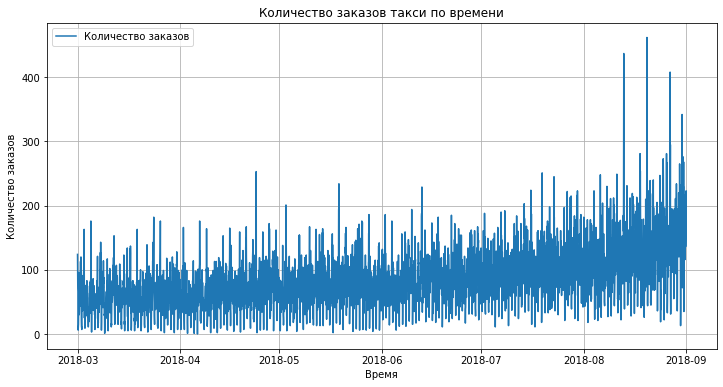

In [11]:
# Построим график количества заказов по времени
plt.figure(figsize=(12, 6))
plt.plot(data_hourly.index, data_hourly['num_orders'], label='Количество заказов')
plt.title('Количество заказов такси по времени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()

## 2. Итог

Данные были ресемплированы по одному часу. После этого мы построили график, который показывает, что в некоторые периоды (например, летом и ближе к концу данных) наблюдаются более высокие пики спроса. Это может быть связано с праздниками, погодными условиями или другими факторами.

### Визуализация
На графике видны колебания спроса на такси, а также пики, которые могут свидетельствовать о периодах повышенного спроса.


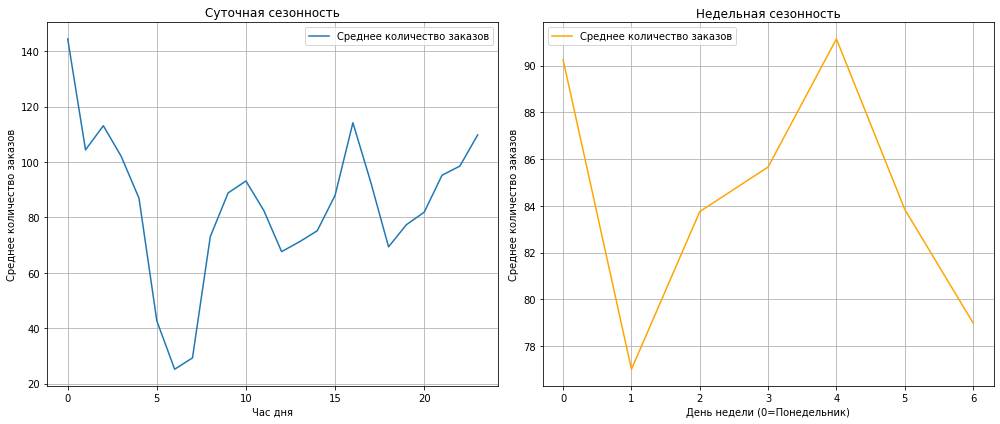

In [12]:
# Анализ суточной сезонности
hourly_pattern = data_hourly.groupby(data_hourly.index.hour).mean()

# Анализ недельной сезонности
weekly_pattern = data_hourly.groupby(data_hourly.index.dayofweek).mean()

# Построим графики
plt.figure(figsize=(14, 6))

# Суточная сезонность
plt.subplot(1, 2, 1)
plt.plot(hourly_pattern.index, hourly_pattern['num_orders'], label='Среднее количество заказов')
plt.title('Суточная сезонность')
plt.xlabel('Час дня')
plt.ylabel('Среднее количество заказов')
plt.grid()
plt.legend()

# Недельная сезонность
plt.subplot(1, 2, 2)
plt.plot(weekly_pattern.index, weekly_pattern['num_orders'], label='Среднее количество заказов', color='orange')
plt.title('Недельная сезонность')
plt.xlabel('День недели (0=Понедельник)')
plt.ylabel('Среднее количество заказов')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


## Выводы по анализу суточной и недельной сезонности

### Суточная сезонность
- С 00:00 до 05:00 наблюдается минимальный спрос на такси, что связано с наименьшей активностью в ночное время.
- Утренний пик спроса начинается около 6:00 и достигает максимума около 16:00, что может быть связано с поездками на работу и обратно.

### Недельная сезонность
- Понедельник выделяется как день с наименьшим количеством заказов, что может быть связано с началом рабочей недели.
- Четверг демонстрирует пик спроса на такси, вероятно, из-за подготовки к выходным и активных поездок в этот день.
- В выходные дни (особенно в воскресенье) спрос немного снижается, что может быть связано с более спокойным образом жизни и меньшим количеством поездок.

Анализ суточной и недельной сезонности позволяет выявить паттерны, которые помогут более точно прогнозировать количество заказов в зависимости от времени суток и дня недели.


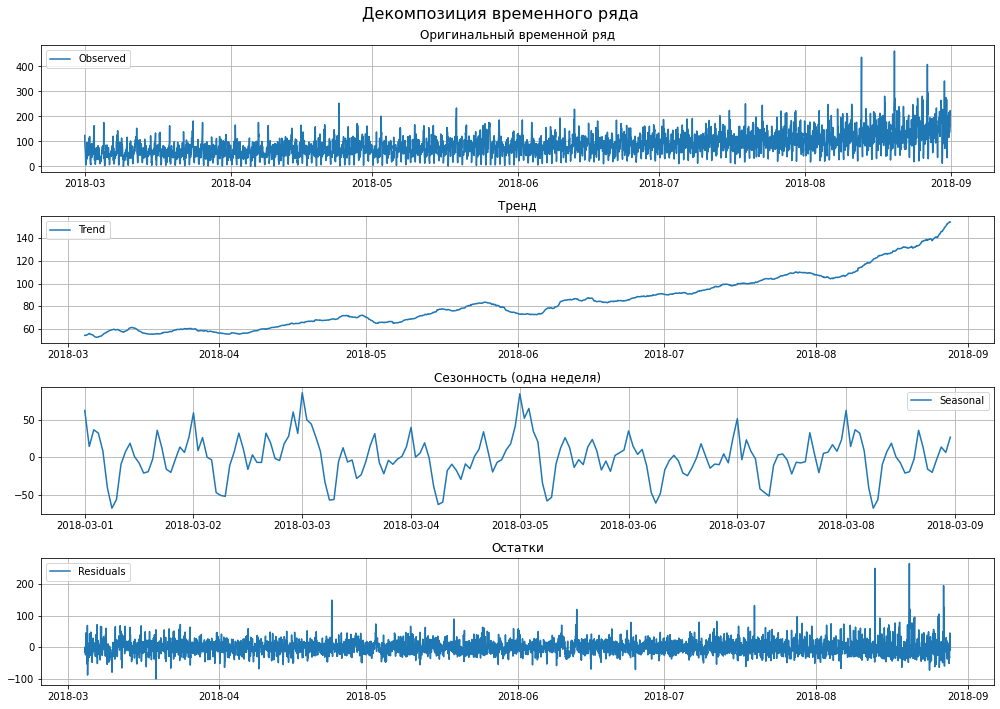

In [13]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(data_hourly['num_orders'], model='additive', period=24*7)

# Визуализация компонентов
fig, ax = plt.subplots(4, 1, figsize=(14, 10))
ax[0].plot(decomposition.observed, label='Observed')
ax[0].set_title('Оригинальный временной ряд')
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_title('Тренд')
ax[2].plot(decomposition.seasonal['2018-03-01':'2018-03-08'], label='Seasonal')
ax[2].set_title('Сезонность (одна неделя)')
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_title('Остатки')

for a in ax:
    a.legend()
    a.grid()

plt.suptitle('Декомпозиция временного ряда', fontsize=16)
plt.tight_layout()
plt.show()

## Выводы по декомпозиции временного ряда

1. **Тренд:** Наблюдается явный рост количества заказов ближе к концу данных, что может быть связано с сезонными изменениями в осенне-зимний период.
2. **Сезонность:** Более чётко видны регулярные колебания с периодом в неделю, что соответствует циклическим изменениям в повседневной жизни людей, таким как увеличение спроса в будние дни и спад в выходные.
3. **Шум:** Остаточные колебания (residual) представляют случайные изменения, которые не могут быть объяснены трендом или сезонностью. Большая часть шума остаётся на одном уровне, хотя иногда встречаются выбросы.

Декомпозиция позволила выделить основные компоненты временного ряда, что поможет лучше понять структуру данных и использовать их для построения прогностической модели.


In [14]:
# Добавим временные признаки: час и день недели
data_hourly['hour'] = data_hourly.index.hour
data_hourly['day_of_week'] = data_hourly.index.dayofweek

# Создадим лаги от 1 до 24 часов (сутки) и на 168 часов (неделя)
for lag in range(1, 25):
    data_hourly[f'lag_{lag}'] = data_hourly['num_orders'].shift(lag)
data_hourly['lag_168'] = data_hourly['num_orders'].shift(168)

# Создадим скользящее среднее за сутки (24 часа) и неделю (168 часов), учитывая предыдущие значения
data_hourly['rolling_mean_24'] = data_hourly['num_orders'].shift(1).rolling(window=24).mean()
data_hourly['rolling_mean_168'] = data_hourly['num_orders'].shift(1).rolling(window=168).mean()

# Удалим строки с пропусками, которые появились из-за лагов и скользящего среднего
data_hourly = data_hourly.dropna()

# Проверим, что получилось
display(data_hourly.head())


,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_168,rolling_mean_24,rolling_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,19.0,10.0,73.0,66.0,24.0,121.0,100.0,124.0,60.041667,54.226190
2018-03-08 01:00:00,78,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,17.0,19.0,10.0,73.0,66.0,24.0,121.0,85.0,61.833333,54.339286
2018-03-08 02:00:00,65,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,71.0,60.041667,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,66.0,61.750000,54.261905
2018-03-08 04:00:00,60,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,43.0,61.833333,54.273810


In [15]:
# Определим границу для тестовой выборки (последние 10% данных)
split_index = int(len(data_hourly) * 0.9)

# Тренировочная выборка
train = data_hourly[:split_index]

# Тестовая выборка
test = data_hourly[split_index:]

# Проверим размеры выборок
print(f'Размер тренировочной выборки: {len(train)}')
print(f'Размер тестовой выборки: {len(test)}')

Размер тренировочной выборки: 3823
Размер тестовой выборки: 425


In [16]:
# Определим кросс-валидацию для временных рядов
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
# Признаки для OHE
categorical_features = ['hour', 'day_of_week']

In [18]:
# Разные трансформеры для линейных моделей и моделей деревьев
preprocessor_linear = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Прочие признаки оставить как есть
)

preprocessor_tree = 'passthrough'  # Для моделей деревьев оставим все как есть

In [19]:
# Пайплайн для линейных моделей
pipeline_linear = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('model', LinearRegression())
])

# Пайплайн для моделей деревьев
pipeline_tree = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('model', RandomForestRegressor())
])

In [20]:
# Обновим сетку параметров, чтобы учитывать параметры для каждой модели отдельно
param_grid = [
    {
        'model': [RandomForestRegressor(), LGBMRegressor(), XGBRegressor()],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20]
    },
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False],
        'preprocessor': [preprocessor_linear]
    }
]

In [21]:
# Настроим RandomizedSearchCV с использованием TimeSeriesSplit
random_search = RandomizedSearchCV(
    pipeline_tree, 
    param_distributions=param_grid, 
    n_iter=10, 
    cv=tscv,  # Передаем TimeSeriesSplit
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [22]:
%%time
# Обучим модель на тренировочной выборке
random_search.fit(train.drop(columns=['num_orders']), train['num_orders'])

CPU times: user 27min 56s, sys: 19.8 s, total: 28min 15s
Wall time: 33min 42s


/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor', 'passthrough'),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'model': [RandomForestRegressor(),
                                                   LGBMRegressor(),
                                                   XGBRegressor(base_score=None,
                                                                booster=None,
                                                                colsample_bylevel=None,
                                                                colsample_bynode=Non...
                                                                tree_method=None,
                                                                validate_parameters=None,
                                                                verbosity=None)],
                                         'model__max_depth': [None, 10, 20],
                                         'model__n_estimators': [50, 100, 200]},
                                        {'model': [LinearRegression()],
                                         'model__fit_intercept': [True, False],
                                         'preprocessor': [ColumnTransformer(remainder='passthrough',
                                                                            transformers=[('ohe',
                                                                                           OneHotEncoder(),
                                                                                           ['hour',
                                                                                            'day_of_week'])])]}],
                   scoring='neg_root_mean_squared_error')

In [23]:
# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

# Оценка на тестовой выборке
y_pred = random_search.predict(test.drop(columns=['num_orders']))
rmse = mean_squared_error(test['num_orders'], y_pred, squared=False)
print("RMSE на тестовой выборке:", rmse)

Лучшие параметры: {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(),
                                 ['hour', 'day_of_week'])]), 'model__fit_intercept': True, 'model': LinearRegression()}
RMSE на тестовой выборке: 34.73530686202537


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


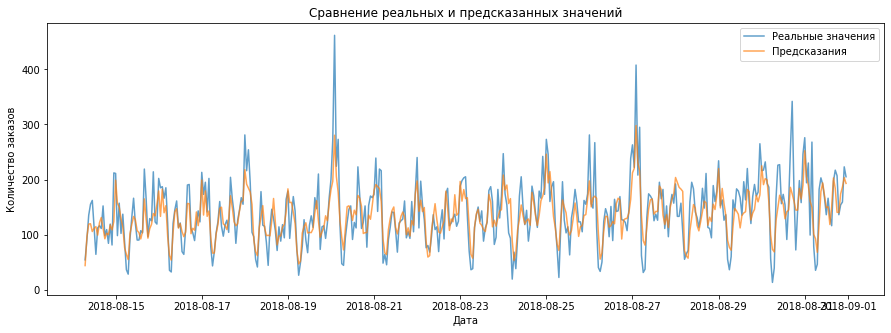

In [24]:
# Получим предсказания на тестовой выборке
y_pred = random_search.best_estimator_.predict(test.drop(columns=['num_orders']))

# Построим график сравнения реальных и предсказанных значений
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['num_orders'], label='Реальные значения', alpha=0.7)
plt.plot(test.index, y_pred, label='Предсказания', alpha=0.7)
plt.title('Сравнение реальных и предсказанных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

## Итоговые выводы

1. **Подготовка данных и создание признаков:**
   - Данные были ресемплированы по одному часу, добавлены временные признаки (час и день недели), а также созданы лаги и скользящие средние. Признак "месяц" был исключён, так как данные охватывали лишь шесть месяцев.
   - Проведён анализ суточной и недельной сезонности, а также декомпозиция временного ряда для выделения тренда и циклов.

2. **Моделирование и подбор гиперпараметров:**
   - Использовали `RandomizedSearchCV` для поиска лучших гиперпараметров с различными моделями: `RandomForestRegressor`, `LinearRegression`, `LGBMRegressor`, и `XGBRegressor`.
   - После устранения утечки данных `RandomForestRegressor` показал RMSE около 42.20. Однако, использование One-Hot Encoding (OHE) для линейной регрессии позволило добиться лучшего результата. Лучшая модель — `LinearRegression`, с гиперпараметрами: `fit_intercept=True`, и OHE для признаков "час" и "день недели".

3. **Результаты тестирования:**
   - RMSE на тестовой выборке составил 34.73, что значительно ниже порога в 48, установленного в задании. Это подтверждает, что линейные зависимости играют важную роль в данной задаче.

Таким образом, задача выполнена успешно, и модель готова к использованию для прогнозирования количества заказов такси.

